In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, MaxPooling2D, Flatten, Dense, Conv2D, Input, BatchNormalization, MaxPool2D, Lambda, Concatenate, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import initializers
import tensorflow.keras.backend as K
import numpy as np
import random
import time
%load_ext tensorboard
import datetime
!rm -rf ./logs/ 

### Make The Dataset

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, 100)
y_test = keras.utils.to_categorical(y_test, 100)

image_size = (32,32,3)

# flip images
x_train_flipped = np.flip(x_train, axis=3)
x_train = np.append(x_train, x_train_flipped, axis=0)
y_train = np.append(y_train, np.copy(y_train), axis=0)
x_train_flipped = None
print('flipped')

# mix it up
x_train, y_train = unison_shuffled_copies(x_train, y_train)
print('permuted')
print(x_train.shape, y_train.shape)

169009152/169001437 [==============================] - 6s 0us/step
flipped
permuted
(100000, 32, 32, 3) (100000, 100)


In [ ]:
classes_train = []
classes_test = []

for i in range(100): 
  classes_train.append([])
  classes_test.append([])
for i in range(len(y_train)):
  classes_train[np.argmax(y_train[i])].append(x_train[i])
for i in range(len(y_test)):
  classes_test[np.argmax(y_test[i])].append(x_test[i])

In [ ]:
word_labels = '''beaver, dolphin, otter, seal, whale, 
aquarium fish, flatfish, ray, shark, trout, 
orchids, poppies, roses, sunflowers, tulips, 
bottles, bowls, cans, cups, plates, 
apples, mushrooms, oranges, pears, sweet peppers, 
clock, computer keyboard, lamp, telephone, television, 
bed, chair, couch, table, wardrobe, 
bee, beetle, butterfly, caterpillar, cockroach, 
bear, leopard, lion, tiger, wolf, 
bridge, castle, house, road, skyscraper, 
cloud, forest, mountain, plain, sea, 
camel, cattle, chimpanzee, elephant, kangaroo, 
fox, porcupine, possum, raccoon, skunk, 
crab, lobster, snail, spider, worm, 
baby, boy, girl, man, woman, 
crocodile, dinosaur, lizard, snake, turtle, 
hamster, mouse, rabbit, shrew, squirrel, 
maple, oak, palm, pine, willow, 
bicycle, bus, motorcycle, pickup truck, train, 
lawn-mower, rocket, streetcar, tank, tractor'''.replace('\n', '').split(', ')

In [ ]:
# for sigmoid, values are 0 when they don't correspond
def make_level(nums):
  ytrain = np.zeros((y_train.shape[0], len(nums)))
  ytest = np.zeros((y_test.shape[0], len(nums)))

  for i in range(y_train.shape[0]):
    arg = np.argmax(y_train[i])
    for x in range(len(nums)):
      if arg in nums[x]:
        ytrain[i][x] = 1.0

  for i in range(y_test.shape[0]):
    arg = np.argmax(y_test[i])
    for x in range(len(nums)):
      if arg in nums[x]:
        ytest[i][x] = 1.0
  
  return ytrain, ytest

In [ ]:
def make_custom_level(allNums, nums):
  ytrain = []
  ytest = []

  for i in range(y_train.shape[0]):
    arg = np.argmax(y_train[i])
    if arg not in allNums: continue
    y = np.zeros(len(nums))
    for x in range(len(nums)):
      if arg in nums[x]:
        y[x] = 1.0
    ytrain.append(y)

  for i in range(y_test.shape[0]):
    arg = np.argmax(y_test[i])
    if arg not in allNums: continue
    y = np.zeros(len(nums))
    for x in range(len(nums)):
      if arg in nums[x]:
        y[x] = 1.0
    ytest.append(y)
  
  return np.array(ytrain), np.array(ytest)

In [ ]:
def make_custom_x(allNums):
  xtrain = []
  xtest = []

  for i in range(x_train.shape[0]):
    arg = np.argmax(y_train[i])
    if arg not in allNums: continue
    xtrain.append(x_train[i])

  for i in range(x_test.shape[0]):
    arg = np.argmax(y_test[i])
    if arg not in allNums: continue
    xtest.append(x_test[i])
  
  return np.array(xtrain), np.array(xtest)

### Model

In [ ]:
# l1 = 1e-4
# l2 = 5e-4

# def mpu(in_shape, root=False, end=False, nums=5, **kwargs):
#   inp = Input(shape=in_shape)
  
#   pred = Conv2D(64, (3,3), padding="same", activation="relu")(inp)
#   pred = Conv2D(64, (3,3), padding="same", activation="relu")(pred)
#   pred = MaxPool2D()(pred)
#   pred = Flatten()(pred)
#   pred = Dense(nums, activation="sigmoid")(pred)

#   base = Conv2D(64, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(inp)
#   base = Conv2D(64, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(base)
#   base = BatchNormalization()(base)
#   base = Dropout(0.5)(base)

#   if root:
#     return Model(inp, base, **kwargs)
#   if end:
#     return Model(inp, pred, **kwargs)

#   return Model(inputs=inp, outputs=[pred, base], **kwargs)

In [ ]:
l1 = 1e-4
l2 = 5e-4
def make_class(cin, filters, classes):
  c = Conv2D(filters, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(cin)
  c = MaxPool2D()(c)
  c = Conv2D(filters, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(c)
  c = Conv2D(filters*2, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(c)
  c = MaxPool2D()(c)
  c = Flatten()(c)
  c = Dense(128, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(c)
  c = Dense(classes, activation="sigmoid")(c)
  return c

def mpu(in_shape, out_classes, name=None, class_only = False):
  inp = Input(shape=in_shape)
  shared = Conv2D(64, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(inp)

  classifier = make_class(shared, 64, out_classes)

  if class_only: return Model(inp, classifier, name=name)

  extra = Conv2D(64, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2))(shared)
  extra = BatchNormalization()(extra)
  extra = Dropout(0.5)(extra)

  return Model(inp, [classifier, extra], name=name)

In [ ]:
class ModelNode:
  def __init__(self, in_shape=None, ind=(-1), nums=5, name=None):
    if in_shape != None:
      self.node = mpu(in_shape, nums, name=name)
    self.branches = []
    self.name = name
    self.ind = [ind] if type(ind) == int else ind
    self.parent = None
    self.num_out = nums

  def __call__(self, model, out_classes=-1):
    if out_classes == -1: out_classes = self.num_out
    if type(model) == ModelNode: 
      model.branches.append(self)
      self.parent = model
      self.extendInd(self.ind)
      shape = model.node.outputs[1].shape[1:]
    elif hasattr(model, "output_shape"): shape = model.output_shape[1:]
    else: shape = model.shape[1:]
    self.node = mpu(shape, out_classes, name=self.name)

    return self
  
  def extend(self, path, nums, transfer=False, name=None):
    if len(path) == 1:
      if path[0] >= len(self.branches):

        x = ModelNode(name=name)(self)
        if transfer:
          x.node.set_weights(self.node.get_weights()) 
      else:
        x = ModelNode(name=name)(self)
        if transfer:
          x.node.set_weights(self.node.get_weights()) 
        self.branches.insert(path[0], x)
        self.branches.pop()
    else:
      b = path.pop(0)
      self.branches[b].extend(path, nums, transfer, name)
  
  def extendInd(self, ind):
    if self.parent:
      self.parent.ind.extend(ind)
      self.parent.extendInd(ind)
  
  def getFullTree(self, input):
    pred, ext = self.node(input)
    levels = [[pred]]
    for i in self.branches:
      model = i.getFullTree(ext)
      for i in range(len(model)):
        if len(levels) <= i+1: levels.append([])
        levels[i+1].extend(model[i])
    
    return levels
  
  def getTreeFromPath(self, input, path):
    inp = Input(shape=input.shape[1:])
    pred, ext = self.node(inp)
    if len(path) == 0: return Model(inputs=inp, outputs=pred, name=self.name)

    branch = self.branches[path.pop(0)]
    model = branch.getTreeFromPath(ext, path)(ext)
    return Model(inputs=inp, outputs=model, name=self.name)

In [ ]:
class SimpleNode:
  def __init__(self, in_shape, out_classes, isRoot=False):
    self.node = mpu(in_shape, out_classes)
    self.branches = []
    self.isRoot = isRoot
  
  def get_tree_path(self, path, input):
    inp = Input(shape=input.shape[1:])
    pred, ext = self.node(inp)
    if len(path) == 0: return Model(inputs=inp, outputs=pred)

    branch = self.branches[path.pop(0)]
    model = branch.get_tree_path(path, ext)(ext)
    return Model(inputs=inp, outputs=model)

  def get_tree(self, input):
    pred, ext = self.node(input)
    levels = [[pred]]
    for i in self.branches:
      model = i.get_tree(ext)
      for i in range(len(model)):
        if len(levels) <= i+1: levels.append([])
        levels[i+1].extend(model[i])
    
    return levels

### Functions For Expanding, Printing, and Saving

In [ ]:
def printTree(tree, spaces=0):
  print(' '*spaces, end='')
  if spaces > 0: print('⮡ ', end="")
  print(tree.name)
  for i in tree.branches:
    if spaces == 0:
      printTree(i, spaces + 1)
    else:
       printTree(i, spaces + 3)

In [ ]:
class Design:
  def __init__(self, design):
    self.design = design if type(design) == list else [design]

  def inds(self):
    inds = []
    for i in range(len(self.design)):
      if type(self.design[i]) == int:
        inds.append(self.design[i])
      else:
        inds.extend(self[i].inds())
    return inds
  
  def isNextLevel(self):
    for i in self.design:
      if type(i) == list:
        return True
    return False

  def nextLevel(self):
    l = []
    for i in self.design:
      if type(i) == list:
        l.extend(i)
    return Design(l)

  def path(self, num):
    p = []
    for i in range(len(self.design)):
      if self.design[i] == num: return [i]
      elif type(self.design[i]) == list:
        d = self[i].path(num)
        if d != None:
          return [i] + d
    return None

  
  def __getitem__(self, num):
    return Design(self.design[num])
  
  def __len__(self):
    return len(self.design)

### Making The Model

In [ ]:
treeInds = []
for i in range(0, 100, 5):
  treeInds.append(list(range(i, i+5)))
design = Design(treeInds)

In [ ]:
nums = []
for i in range(20):
  nums.append(range(i*5, i*5+5))
ytrain, ytest = make_level(nums)

In [ ]:
sgd = optimizers.SGD(learning_rate=0.0005, momentum=0.9)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

inp = Input(shape=(32,32,3))
m = SimpleNode(in_shape=(32,32,3), out_classes=20)

model = Model(inp, m.node(inp)[0])

# model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# model.fit(x_train, ytrain, epochs=50, batch_size=64, validation_data=(x_test, ytest), callbacks=[es])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(x_train, ytrain, epochs=50, batch_size=64, validation_data=(x_test, ytest), callbacks=[es])

Epoch 1/50
1563/1563 [==============================] - 9s 6ms/step - loss: 5.2285 - accuracy: 0.0511 - val_loss: 5.1614 - val_accuracy: 0.0507
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 5.0893 - accuracy: 0.0639 - val_loss: 5.0112 - val_accuracy: 0.0713
Epoch 3/50
1563/1563 [==============================] - 9s 6ms/step - loss: 4.9279 - accuracy: 0.0856 - val_loss: 4.8643 - val_accuracy: 0.0871
Epoch 4/50
1563/1563 [==============================] - 9s 6ms/step - loss: 4.7745 - accuracy: 0.1037 - val_loss: 4.7289 - val_accuracy: 0.0931
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 4.6334 - accuracy: 0.1179 - val_loss: 4.5729 - val_accuracy: 0.1183
Epoch 6/50
1563/1563 [==============================] - 9s 6ms/step - loss: 4.4954 - accuracy: 0.1312 - val_loss: 4.4459 - val_accuracy: 0.1319
Epoch 7/50
1563/1563 [==============================] - 9s 6ms/step - loss: 4.3618 - accuracy: 0.1431 - val_loss: 4.3047 - val_accuracy:

In [ ]:
for i in range(20):
  m.branches.append(SimpleNode(in_shape=m.node.outputs[1].shape[1:], out_classes=5))
  ytrain, ytest = make_level([[x] for x in range(i*5, i*5+5)])
  model = m.get_tree_path([i], inp)
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  model.fit(x_train, ytrain, epochs=50, batch_size=64, validation_data=(x_test, ytest), callbacks=[es])

  tree = m.get_tree(inp)
  p2 = tree[1] if len(tree[1]) < 2 else Concatenate()(tree[1])
  full = Model(inp, [tree[0][0], p2], name='full')
  full.save('/content/drive/My Drive/mpua_pretrain_only_prior.hdf5')



Epoch 1/50
1563/1563 [==============================] - 15s 9ms/step - loss: 3.2040 - accuracy: 0.2995 - val_loss: 3.0865 - val_accuracy: 0.1130
Epoch 2/50
1563/1563 [==============================] - 14s 9ms/step - loss: 2.9807 - accuracy: 0.1621 - val_loss: 2.8818 - val_accuracy: 0.1440
Epoch 3/50
1563/1563 [==============================] - 14s 9ms/step - loss: 2.7873 - accuracy: 0.1490 - val_loss: 2.6957 - val_accuracy: 0.1234
Epoch 4/50
1563/1563 [==============================] - 14s 9ms/step - loss: 2.6074 - accuracy: 0.1428 - val_loss: 2.5264 - val_accuracy: 0.0989
Epoch 5/50
1563/1563 [==============================] - 14s 9ms/step - loss: 2.4394 - accuracy: 0.1371 - val_loss: 2.3619 - val_accuracy: 0.0973
Epoch 6/50
1563/1563 [==============================] - 15s 10ms/step - loss: 2.2814 - accuracy: 0.1399 - val_loss: 2.2074 - val_accuracy: 0.1403
Epoch 7/50
1563/1563 [==============================] - 14s 9ms/step - loss: 2.1322 - accuracy: 0.1387 - val_loss: 2.0646 - val_a

In [ ]:
# m3 = SimpleNode((32,32,3), 20)
# m3.node = m2.node
# m3.branches = m2.branches


In [22]:
tree = m.get_tree(inp)
full = Model(inp, [tree[0][0], Concatenate()(tree[1])], name='full')
full.save('/content/drive/My Drive/mpua_pretrain_only.hdf5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

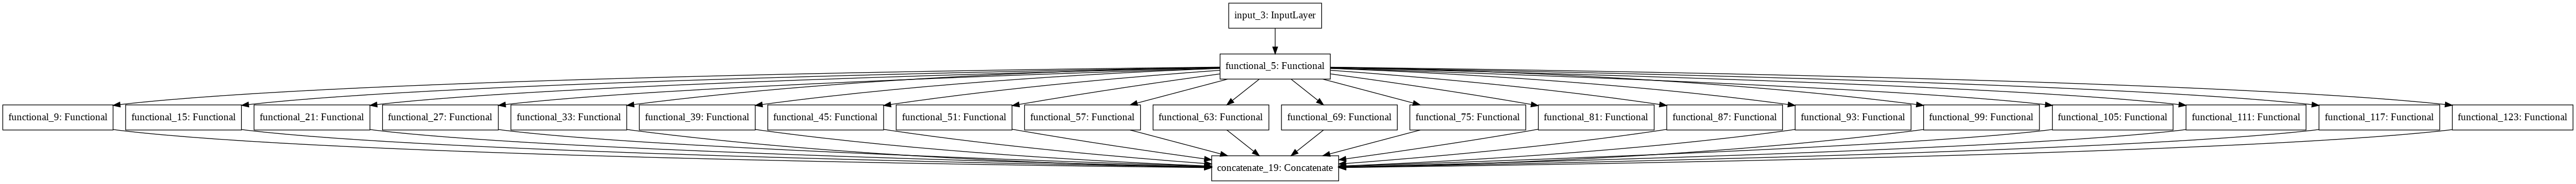

In [23]:
plot_model(full)

In [ ]:
full.save('full_mpu_a2.hdf5')

In [ ]:
full.outputs

[<tf.Tensor 'functional_1/dense_1/Sigmoid_21:0' shape=(None, 20) dtype=float32>,
 <tf.Tensor 'concatenate/concat:0' shape=(None, 100) dtype=float32>]

In [ ]:
ytrain.shape

(100000, 20)

In [39]:
nums = []
for i in range(20):
  nums.append(range(i*5, i*5+5))
ytrain, ytest = make_level(nums)

full.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


  

In [40]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
full.fit(x_train, [ytrain, y_train], epochs=100, batch_size=64, validation_data=(x_test, [ytest, y_test]), callbacks=[es])
full.save('mpu_a_pretrain_and_full.hdf5')

Epoch 1/100
1563/1563 [==============================] - 156s 100ms/step - loss: 7.9167 - functional_5_loss: 2.9981 - concatenate_19_loss: 3.1441 - functional_5_accuracy: 0.0500 - concatenate_19_accuracy: 0.2361 - val_loss: 8.0068 - val_functional_5_loss: 2.9973 - val_concatenate_19_loss: 3.2656 - val_functional_5_accuracy: 0.0500 - val_concatenate_19_accuracy: 0.2373
Epoch 2/100
1563/1563 [==============================] - 153s 98ms/step - loss: 7.5968 - functional_5_loss: 2.9970 - concatenate_19_loss: 2.8895 - functional_5_accuracy: 0.0500 - concatenate_19_accuracy: 0.2876 - val_loss: 7.8514 - val_functional_5_loss: 2.9967 - val_concatenate_19_loss: 3.1823 - val_functional_5_accuracy: 0.0500 - val_concatenate_19_accuracy: 0.2540
Epoch 3/100
1563/1563 [==============================] - 153s 98ms/step - loss: 7.4019 - functional_5_loss: 2.9966 - concatenate_19_loss: 2.7655 - functional_5_accuracy: 0.0488 - concatenate_19_accuracy: 0.3126 - val_loss: 7.8086 - val_functional_5_loss: 2.99

ROUND 1 ENDS HERE

### Test The Networks

In [ ]:
full = keras.models.load_model('/content/full_finished_mpu_a.hdf5')

In [41]:
import copy
raw = full.predict(x_test)
tests = copy.deepcopy(raw)

In [ ]:
[(np.argmax(tests[1][i]), np.argmax(y_test[i])) for i in range(500)]

In [42]:
abovep1 = 0
for i in tests[1]:
  if np.argmax(i) > 0:
    abovep1 += 1
print(abovep1, "/", len(tests[0]), '(', str(100*abovep1/len(tests[0])) + '%', ')')

9949 / 10000 ( 99.49% )


full

In [43]:
correct = 0
for i in range(len(tests[1])):
  if np.argmax(tests[1][i]) == np.argmax(y_test[i]):
    correct += 1
print(correct, len(tests[1]), correct / len(tests[1]))

2821 10000 0.2821


top n

In [45]:
correct = 0
for i in range(len(tests[1])):
  pred = list(reversed(np.argsort(tests[1][i])))
  if np.argmax(y_test[i]) in pred[:5]:
    correct += 1
print(correct / len(tests[1]))

0.5551


single

In [46]:
correct = 0
for i in range(len(tests[1])):
  l1 = np.argmax(tests[0][i])
  l2 = np.argmax(tests[1][i][l1*5 : l1*5 + 5]) + l1*5
  if l2 == np.argmax(y_test[i]):
    correct += 1
print(correct, correct / len(tests[1]))

365 0.0365


conditional

In [47]:
for threshold in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
  correct = 0
  tests = copy.deepcopy(raw)
  for i in range(len(tests[1])):
    for j in range(len(tests[0][i])):
      if tests[0][i][j] < threshold:
        tests[0][i][j] = 0
    for j in range(len(tests[1][i])):
      if tests[0][i][j//5] == 0:
        tests[1][i][j] = 0
        continue
      if tests[1][i][j] < threshold:
        tests[1][i][j] = 0
    
    if np.argmax(tests[1][i]) == np.argmax(y_test[i]):
      correct += 1
  print(str(threshold) + ":", correct / len(tests[1]))

1e-06: 0.2821
1e-05: 0.2821
0.0001: 0.282
0.001: 0.277
0.01: 0.2364
0.1: 0.143
